In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sktime.forecasting.model_selection import temporal_train_test_split

from sktime.transformations.series.outlier_detection import HampelFilter
from sktime.transformations.series.impute import Imputer
from sktime.transformations.series.boxcox import BoxCoxTransformer
from sktime.transformations.series.detrend import Detrender
from sktime.forecasting.trend import PolynomialTrendForecaster
from sklearn.preprocessing import StandardScaler
from sktime.transformations.series.adapt import TabularToSeriesAdaptor

from sktime.transformations.compose import TransformerPipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.transformations.series.fourier import FourierFeatures
from sktime.transformations.series.date import DateTimeFeatures

from sktime.forecasting.compose import TransformedTargetForecaster
from sktime.forecasting.compose import make_reduction

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import TargetEncoder

from catboost import CatBoostRegressor

from sktime.transformations.compose  import TransformerPipeline
import shap as sp

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

In [2]:
pd.options.display.max_columns = None

# I/ Load Dataset

In [3]:
df = pd.read_csv('daily-website-visitors.csv')[["Date", "Page.Loads", "Unique.Visits", "First.Time.Visits", "Returning.Visits"]]

df = df.rename(columns={"Date": 'ds', 
                        "Page.Loads": 'y1',
                        "Unique.Visits": 'y2',
                        "First.Time.Visits": 'y3',
                        "Returning.Visits": 'y4'
                       })

In [4]:
targets = ['y1', 'y2', 'y3', 'y4']

In [5]:
df['ds'] = pd.to_datetime(df.ds, yearfirst = True)

for target in targets : 
    df[target] = df[target].str.replace(',','.').astype("float")

df = df.set_index('ds')
df.index.freq = 'd'

In [6]:
H = 365

# II/ Pipeline Building

In [7]:
def CategoricalEncoding(X_train, X_test, y_tr=None, EncodingType='OHE', col=None, index_col=True):
    X_tr, X_ts = X_train.copy(), X_test.copy()
    if index_col:
        col_name = f'index_{col}'
        X_tr[col_name] = X_tr.reset_index(col)[col].values
        X_ts[col_name] = X_ts.reset_index(col)[col].values
    else:
        col_name = col
    
    if EncodingType == 'OHE':
        ohe = OneHotEncoder(sparse_output=False).fit(X_tr[[col_name]])
        
        X_tr[ohe.get_feature_names_out()] = ohe.transform(X_tr[[col_name]])
        X_ts[ohe.get_feature_names_out()] = ohe.transform(X_ts[[col_name]])

        X_tr = X_tr.drop(col_name, axis=1)
        X_ts = X_ts.drop(col_name, axis=1)

    if EncodingType == 'Ordinal':
        le = OrdinalEncoder()
        
        X_tr[col_name] = le.fit_transform(X_tr[[col_name]])
        X_ts[col_name] = le.transform(X_ts[[col_name]])

    if EncodingType == 'Target':
        te = TargetEncoder(target_type='continuous', cv=2,)

        X_tr[col_name] = te.fit_transform(X_tr[[col_name]], y_tr.values.ravel())
        X_ts[col_name] = te.transform(X_ts[[col_name]])

    return X_tr, X_ts

In [8]:
from sklearn.base import BaseEstimator, RegressorMixin

class CatBoostRegressorWrapper(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs
        self.cat_features = kwargs.get('cat_features', [])
        self.model = CatBoostRegressor(**kwargs)

    def fit(self, X, y):
        X_ = X.copy()
        if self.cat_features:
            X_[self.cat_features] = X_[self.cat_features].astype(str).replace('nan', 'NoValue').astype('category')
        self.model.fit(X_, y)
        return self

    def predict(self, X):
        X_ = X.copy()
        if self.cat_features:
            X_[self.cat_features] = X_[self.cat_features].astype(str).replace('nan', 'NoValue').astype('category')
        return self.model.predict(X_)
    
    def get_model(self, deep=True):
        return self.model
    
    def get_params(self, deep=True):
        return self.kwargs

    def set_params(self, **params):
        self.kwargs.update(params)
        self.cat_features = self.kwargs.get('cat_features', [])
        self.model = CatBoostRegressor(**self.kwargs)
        return self

In [9]:
filter_kwargs = {'window_length': 16, 'n_sigma': 3}

fourrier_kwargs = {'sp_list': [365.25, 30.44, 7], 'fourier_terms_list': [8, 2, 1], 'freq': 'D', 'keep_original_columns': True}

date_kwargs = {'manual_selection' : ["day_of_week", "is_weekend", "week_of_month"], 'keep_original_columns': True}

window_kwargs =  {'lag_feature' : {
        "lag": list(range(1, 8)) + [14],
        "mean": [[1, 7], [1, 28], [7,7], [14, 7], [22,7]],
        "std": [[1, 7], [1, 28], [7,7], [14, 7], [22,7]],
    }
}

catboost_kwargs = {'loss_function': "RMSE", 'has_time': True, 'verbose': False,
                  'cat_features': ['day_of_week']}

forecast_kwargs = {'window_length': None, 'strategy': "recursive", 'pooling': 'global', 'scitype': 'tabular-regressor'}

In [10]:
featurizer = TransformerPipeline(
        steps = [
            ("fourier_featurizer", FourierFeatures(**fourrier_kwargs)),
            ("datetime_featurizer", DateTimeFeatures(**date_kwargs)),
        ]
    )
forecaster = make_reduction(CatBoostRegressorWrapper(**catboost_kwargs),
                            **forecast_kwargs,
                            transformers=[WindowSummarizer(**window_kwargs, )])

In [11]:
# from sktime.forecasting.conformal import ConformalIntervals  
# conformal_forecaster = ConformalIntervals(forecaster, method='conformal_bonferroni')  

In [12]:
pipe = TransformedTargetForecaster(steps=[
        ("outlier", HampelFilter(**filter_kwargs)),
        ("imputer_interp", Imputer(method="linear")),
        ("imputer_extrap", Imputer(method="nearest")),
        #("boxcox", BoxCoxTransformer()),
        #("detrender", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
        ("scale", TabularToSeriesAdaptor(StandardScaler())),
        ("forecaster", forecaster),

])

# III/ Pre-Preprocessing

In [13]:
y_train, y_test = temporal_train_test_split(df[targets], test_size=H)
index_train, index_test = y_train.index, y_test.index
double_index_full = pd.DataFrame(index_train).merge(pd.DataFrame(index_test),how='outer').merge(pd.Series(targets, name='target'), how='cross').set_index(['target', 'ds'])

In [14]:
y_train = pd.melt(y_train.reset_index(), id_vars=['ds'], value_vars=['y1', 'y2', 'y3', 'y4'], var_name='target', value_name='y').sort_values(by=['ds', 'target']).set_index(['target', 'ds'])
y_test = pd.melt(y_test.reset_index(), id_vars=['ds'], value_vars=['y1', 'y2', 'y3', 'y4'], var_name='target', value_name='y').sort_values(by=['ds', 'target']).set_index(['target', 'ds'])

In [15]:
X_full = featurizer.fit_transform(double_index_full)
X_train, X_test = X_full.loc[(slice(None), index_train),:], X_full.loc[(slice(None), index_test),:]

In [16]:
X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'OHE', 'target')
X_train, X_test = CategoricalEncoding(X_train, X_test, y_train, 'Ordinal', 'day_of_week', False)

In [17]:
print(X_train.shape)
X_train.sort_values(by='ds').head()

(7208, 29)


,,sin_365.25_1,cos_365.25_1,sin_365.25_2,cos_365.25_2,sin_365.25_3,cos_365.25_3,sin_365.25_4,cos_365.25_4,sin_365.25_5,cos_365.25_5,sin_365.25_6,cos_365.25_6,sin_365.25_7,cos_365.25_7,sin_365.25_8,cos_365.25_8,sin_30.44_1,cos_30.44_1,sin_30.44_2,cos_30.44_2,sin_7_1,cos_7_1,week_of_month,day_of_week,is_weekend,index_target_y1,index_target_y2,index_target_y3,index_target_y4
target,ds,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
y1,2014-09-14,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.00000,2,6.0,1,1.0,0.0,0.0,0.0
y3,2014-09-14,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.00000,2,6.0,1,0.0,0.0,1.0,0.0
y4,2014-09-14,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.00000,2,6.0,1,0.0,0.0,0.0,1.0
y2,2014-09-14,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,1.000000,0.000000,1.000000,0.000000,1.00000,2,6.0,1,0.0,1.0,0.0,0.0
y1,2014-09-15,0.017202,0.999852,0.034398,0.999408,0.051584,0.998669,0.068755,0.997634,0.085906,0.996303,0.103031,0.994678,0.120126,0.992759,0.137185,0.990545,0.20495,0.978773,0.401198,0.915991,0.781831,0.62349,3,0.0,0,1.0,0.0,0.0,0.0


# IV/ Fitting

In [18]:
pipe.fit(y_train, X_train);

In [19]:
y_pred = pipe.predict(np.arange(1,H+1).tolist(), X_test)

In [20]:
y_pred

y
target ds                    
y1     2019-08-21    3.933731
       2019-08-22    3.787315
       2019-08-23    3.096046
       2019-08-24    1.889146
       2019-08-25    2.425333
...                       ...
y4     2020-08-15  284.924910
       2020-08-16  294.218772
       2020-08-17  477.517049
       2020-08-18  488.941255
       2020-08-19  482.494404

[1460 rows x 1 columns]

# V/ Result

Newtech:
MSE: 0.34160462428109445
MAPE: 0.11191867090647402


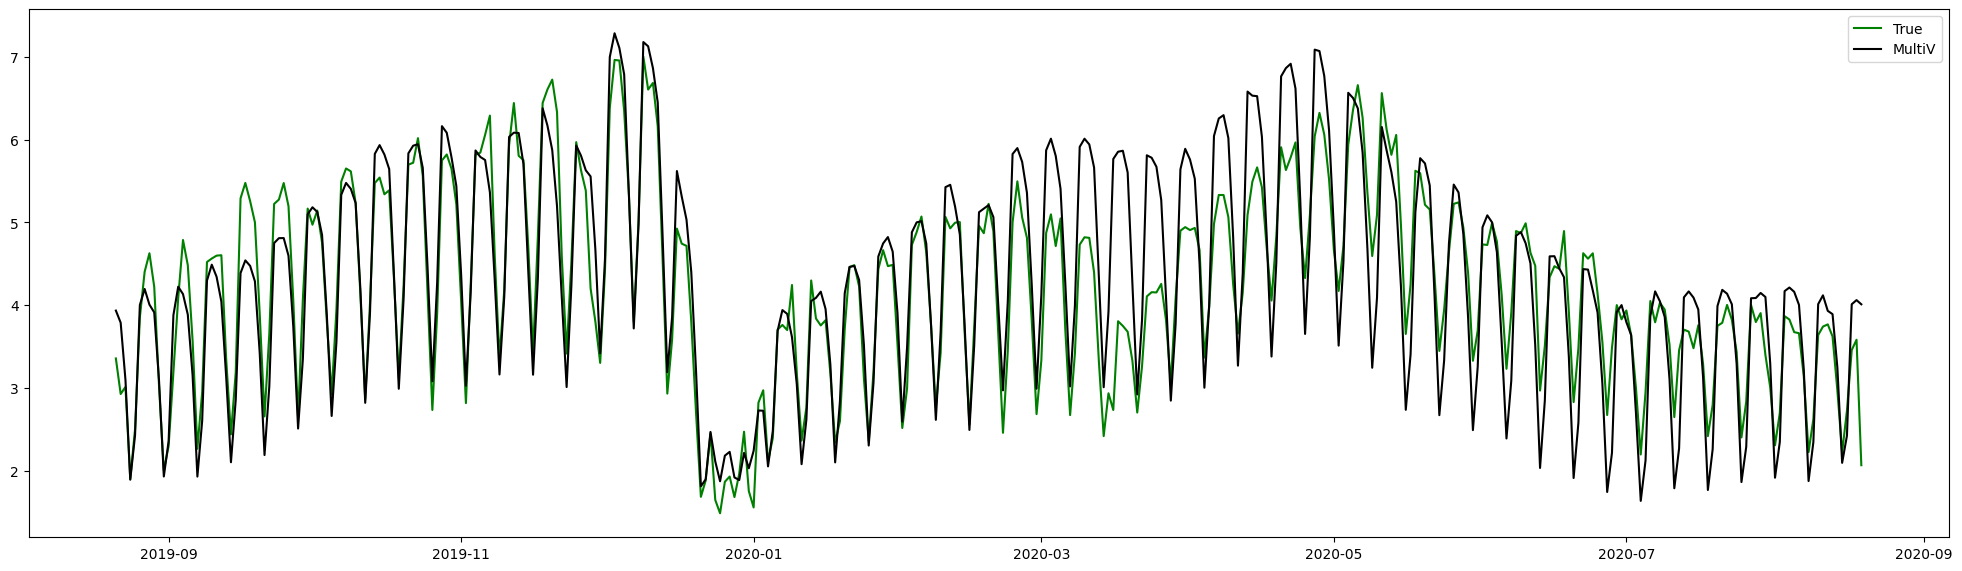

Newtech:
MSE: 0.16765919729442288
MAPE: 0.10782466508930771


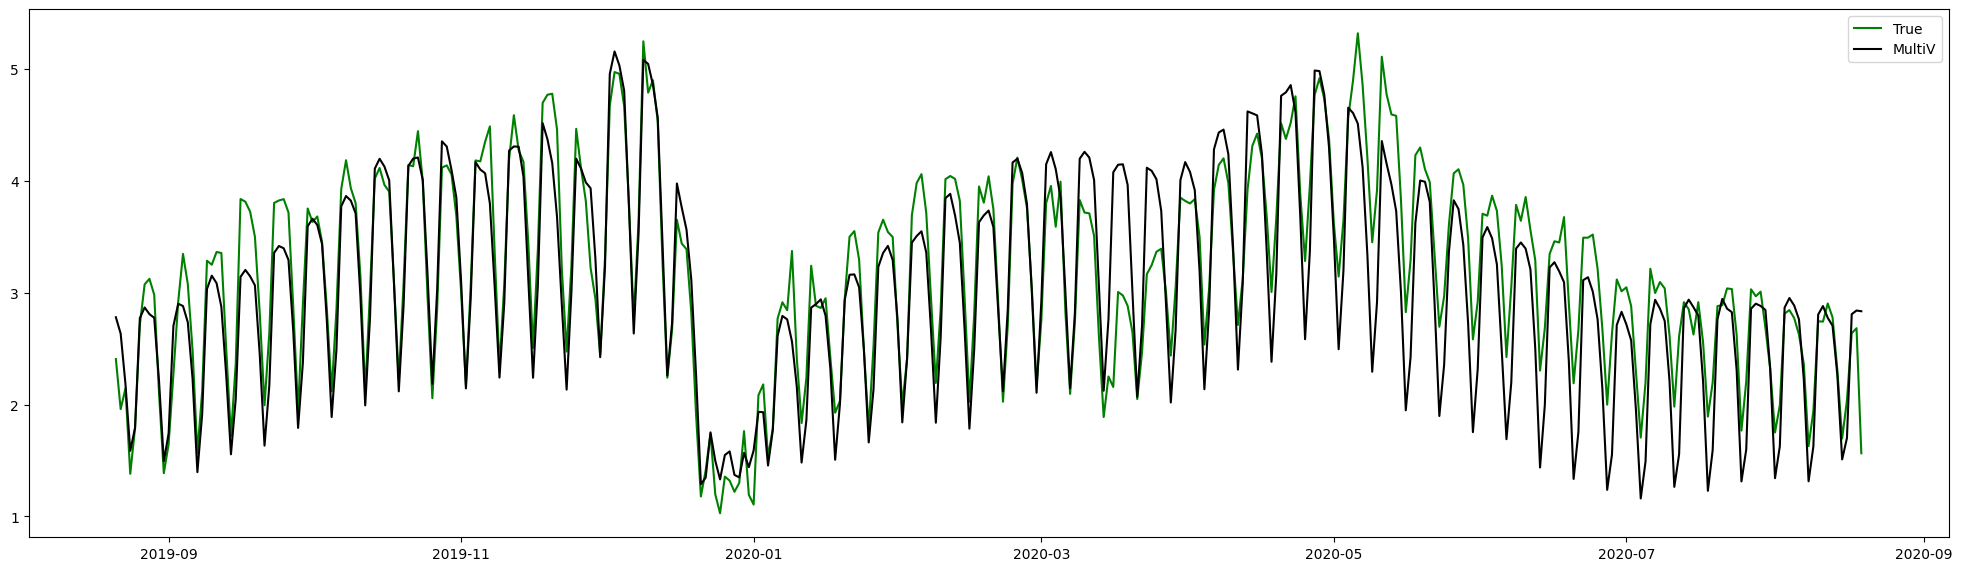

Newtech:
MSE: 6654.925639816354
MAPE: 0.12074209856230124


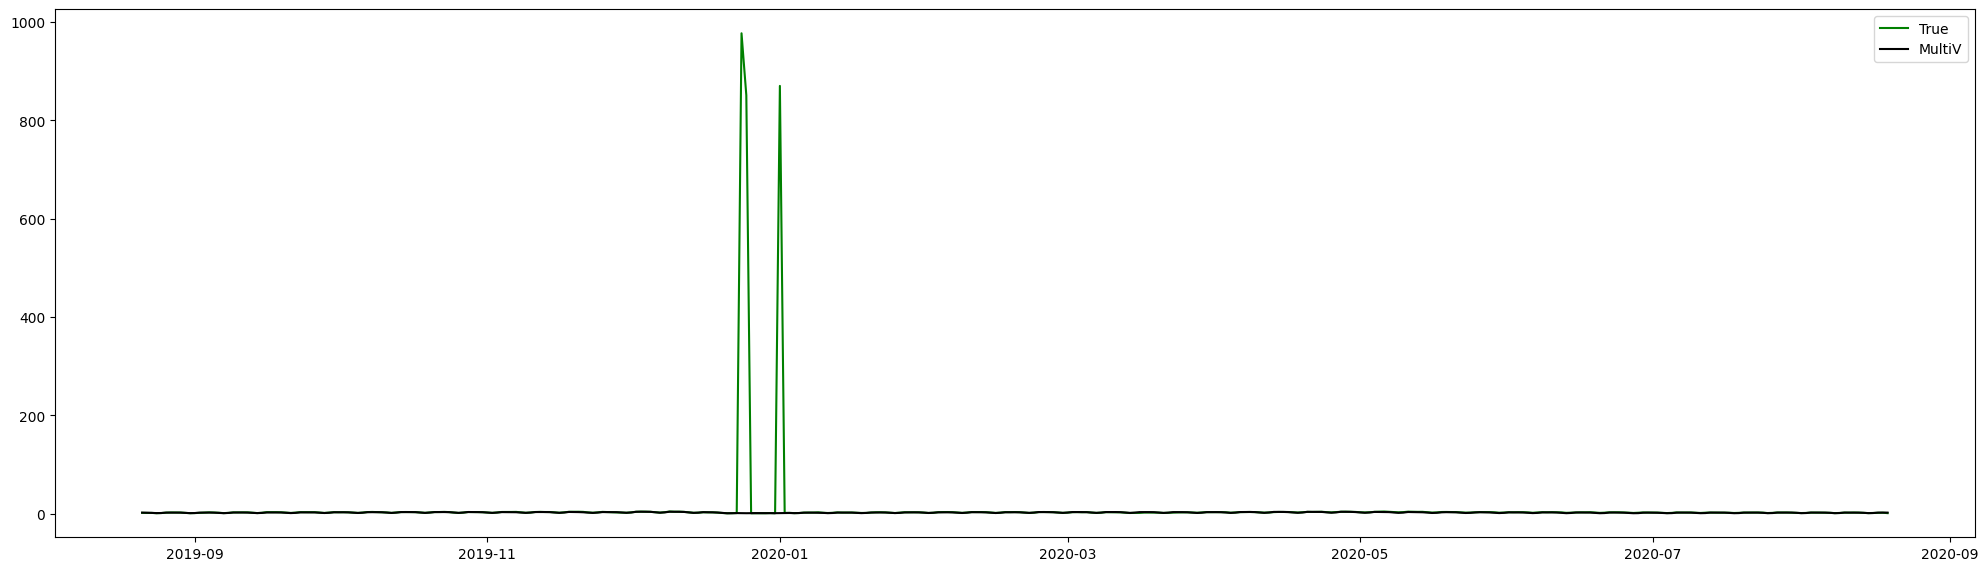

Newtech:
MSE: 4082.357708056579
MAPE: 0.11146796644836789


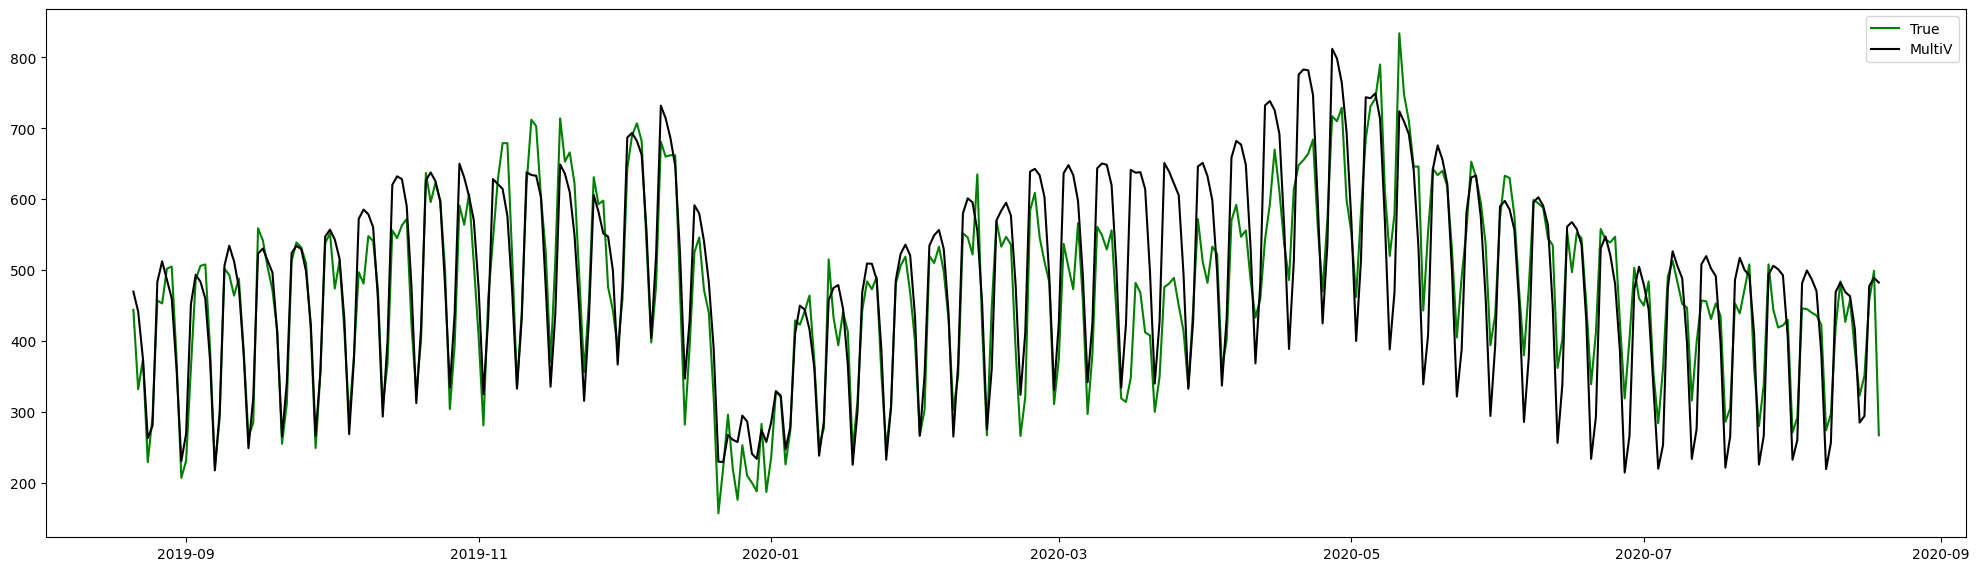

In [21]:
for target in targets:
    y_test_tmp = y_test.loc[target]
    y_pred_tmp = y_pred.loc[target]
    
    print('Newtech:')
    print("MSE:", mean_squared_error(y_test_tmp, y_pred_tmp))
    print("MAPE:", mean_absolute_percentage_error(y_test_tmp, y_pred_tmp))

    plt.plot(y_test_tmp.index, y_test_tmp.values, color='green', label = 'True')
    plt.plot(y_pred_tmp.index,  y_pred_tmp.values, color='black', label='MultiV')

    plt.legend()
    plt.subplots_adjust(left=-1, bottom=-1, right=2, top=0.1, wspace=0.25, hspace=0.5)
    plt.show()

# VI/ Model explicativity

In [22]:
model_sp = pipe.get_fitted_params()['forecaster'].get_fitted_params()['estimator'].get_model()
cat_features_sp = model_sp.get_params()['cat_features']

In [23]:
from sktime.transformations.compose  import TransformerPipeline

pipe_sp = TransformerPipeline(steps=[
    ("outlier", HampelFilter(**filter_kwargs)),
    ("imputer_interp", Imputer(method="linear")),
    ("imputer_extrap", Imputer(method="nearest")),
    ("boxcox", BoxCoxTransformer()),
    ("detrender", Detrender(forecaster=PolynomialTrendForecaster(degree=1))),
    ("scale", TabularToSeriesAdaptor(StandardScaler())),
])

y_sp = pipe_sp.fit_transform(y_train)

In [24]:
X_sp = pd.concat([WindowSummarizer(**window_kwargs, ).fit_transform(y_sp), X_train])
X_sp = X_sp[model_sp.feature_names_]
X_sp[cat_features_sp] = X_sp[cat_features_sp].astype(str).replace('nan', 'NoValue').astype('category')

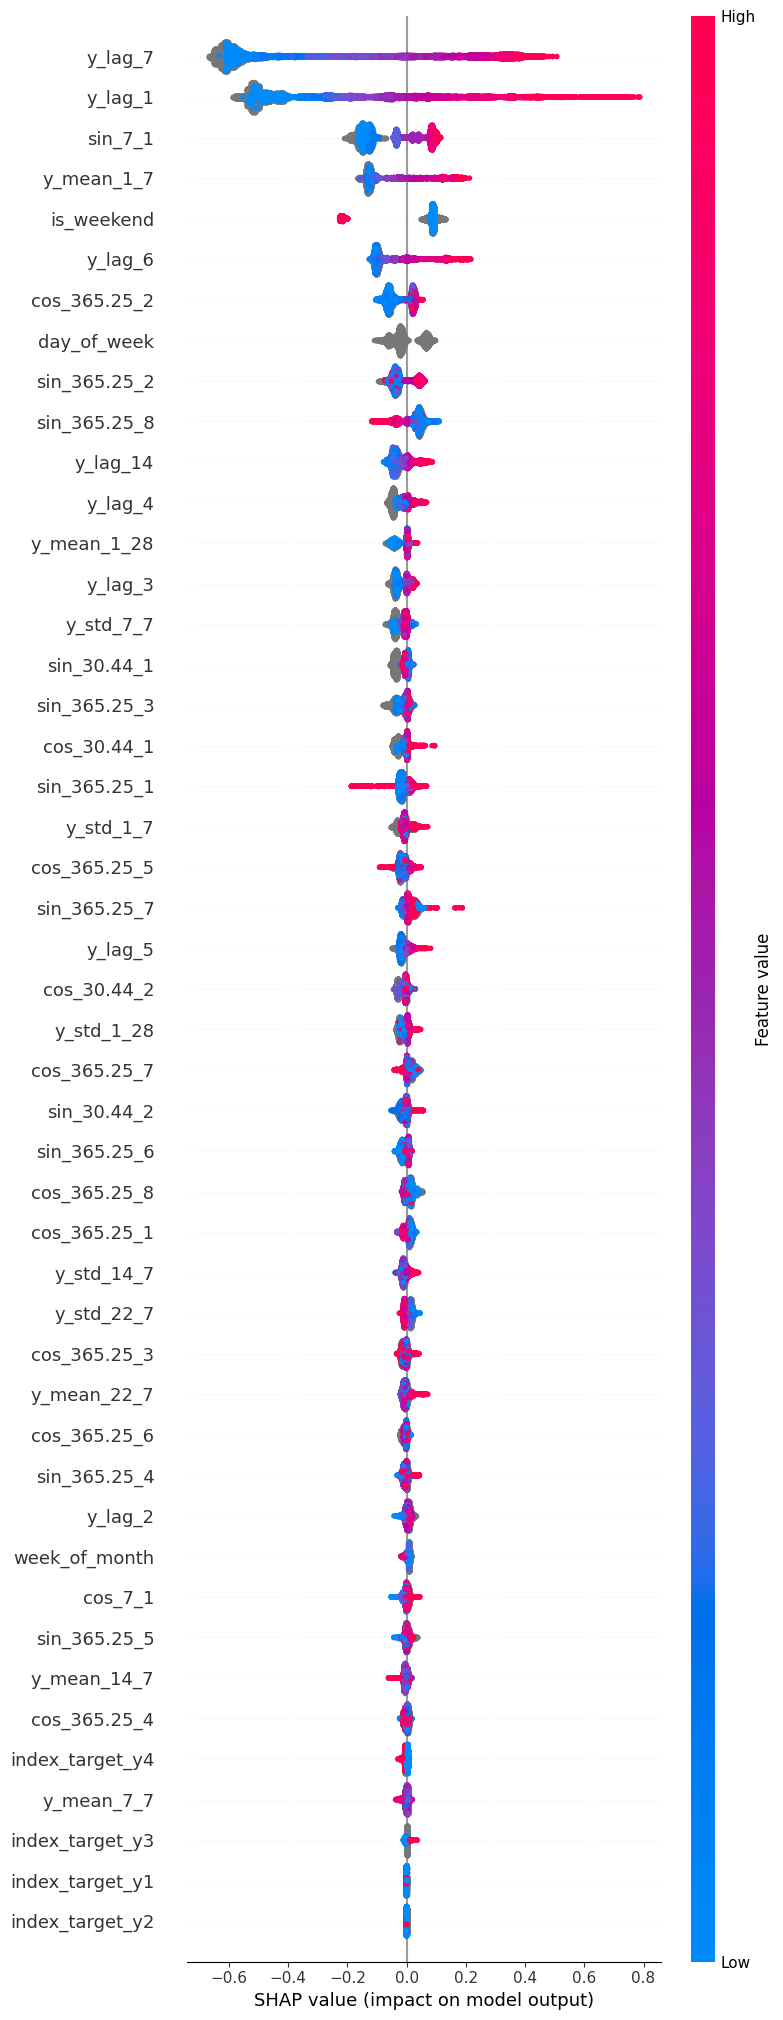

In [25]:
explainer = sp.TreeExplainer(model_sp)
shap_values = explainer.shap_values(X_sp)

sp.summary_plot(shap_values, X_sp, max_display=50)
plt.show()